In [23]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [46]:
# Loading data
train = pd.read_csv('../../data/train_data_1031.csv', index_col='id')
test = pd.read_csv('../../data/test_data_1031.csv', index_col='id')
X_train = train.drop(columns=['playtime_forever'])
X1_train = X_train
X2_train = train.loc[train['playtime_forever'] > 0, :].copy()
is_play = train['playtime_forever'].copy()
is_play.loc[is_play > 0] = 1
y1_train = is_play
y2_train = X2_train['playtime_forever']
X2_train = X2_train.drop(columns=['playtime_forever'])

In [57]:
# Tuning hyperparameter
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr_init = RandomForestRegressor()
rfc_init = RandomForestClassifier()

# rfc = RandomizedSearchCV(estimator = rfc_init, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# rfc.fit(X_train, y1_train)
rfr = RandomizedSearchCV(estimator = rfr_init, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rfr.fit(X2_train, y2_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [59]:
rfr.best_score_

0.14779283719493966

In [60]:
rfr.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [48]:
best_params = {'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}
rfc_init = RandomForestClassifier(**best_params)
rfc_init.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(rfc_init, X_train, y1_train, cv=5, scoring='f1')
cv_results['test_score'].mean()

0.7351339534229877

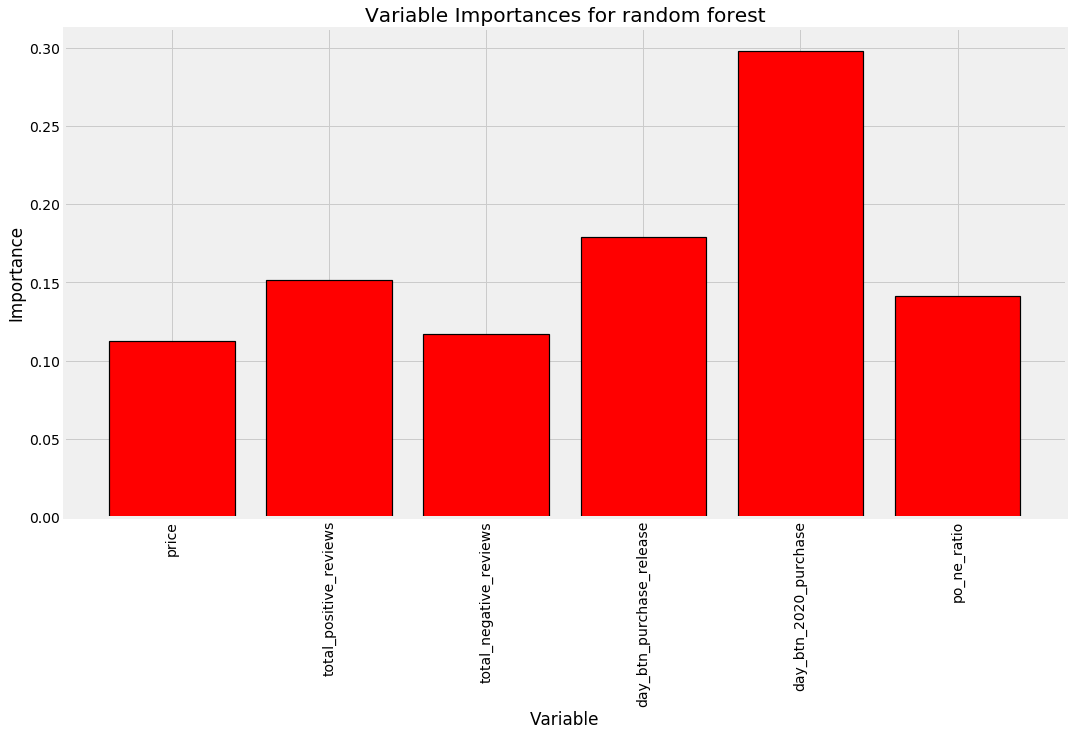

In [50]:
feature_list = list(X_train.columns)
importances = list(rfc_init.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

plt.figure(figsize=(16,9))
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances for random forest');

In [61]:
best_params = {'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}
rfr_init = RandomForestRegressor(**best_params)
rfr_init.fit(X2_train, y2_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=800,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [62]:
cv_results = cross_validate(rfr_init, X2_train, y2_train, cv=5, scoring='neg_mean_squared_error')
-cv_results['test_score'].mean()

189.18168307127502

In [63]:
rfr_init.fit(X2_train, y2_train)
rfc_init.fit(X1_train, y1_train)
is_play = rfc_init.predict(test)
playtime_forever = rfr_init.predict(test)
submission = pd.DataFrame(data={
    'playtime_forever': playtime_forever,
    'is_play': is_play
})
submission.loc[submission['is_play'] == 0, 'playtime_forever'] = 0
submission = submission.drop(columns=['is_play'])
submission.index.name = 'id'
submission.to_csv('../../submission/cla_reg_datasplit/rf_1106_01.csv')